## Create vocal only fies
All song files should be in the 'resources/dataset/Audio/' folder as a .wav file

In [ ]:
import sys
!{sys.executable} -m pip install spleeter

In [1]:
import os
import spleeter
from spleeter.separator import Separator
import soundfile as sf

# Using embedded configuration.
separator = Separator('spleeter:2stems')

In [ ]:
# Use audio loader explicitly for loading audio waveform:
from spleeter.audio.adapter import AudioAdapter

audio_loader = AudioAdapter.default()
sample_rate = 44100
i=0
loc='./resources/dataset/Audio/'
for file_name in os.listdir(loc):
    if file_name.endswith(".wav"):
        print(file_name)
        name=file_name[:-4]
        waveform, _ = audio_loader.load(loc+file_name, sample_rate=sample_rate)

        # Perform the separation :
        prediction = separator.separate(waveform)
        sf.write('./resources/dataset/Audio/vocal_only/'+name+'_vocal.wav', prediction['vocals'], 44100)

## Labeling the blocks on ground truth

All songs should have a _vocal.wav file in the 'resources/dataset/Audio/vocal_only/' folder \
The folder 'resources/dataset/Annotations/final/' should contain a file named annotations.csv

In [3]:
import os
import pandas as pd
import librosa
import soundfile as sf
import numpy as np
import math

In [4]:
# BLOCK AUDIO
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    t_mid = t + (0.5*blockSize/fs)
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t,t_mid)

In [ ]:
lut=pd.read_csv('./resources/dataset/Annotations/final/annotations.csv')

i=0
for video_id in lut['video_id'].unique():
    fp='./resources/dataset/Audio/vocal_only/'+video_id+'_vocal.wav'
    #print(fp)
    x,sr = librosa.load(fp,sr=44100,mono=True)
    blockSize = int(sr * 1)
    hopSize = int(sr * 0.5)

    xb,t,t_mid = block_audio(x,blockSize,hopSize,sr)
    labels=[]
    for ts in t_mid:
        for idx,row in lut[lut['video_id'] == video_id].reset_index().iterrows():
            annotated_start = row['timestamp_start']
            annotated_end = row['timestamp_end']
            if annotated_start <= ts <= annotated_end:
                labels.append(row['scream_type'])
                break
        if ~(annotated_start <= ts <= annotated_end):
            labels.append('no_vocals')
    # Create new dataframs
    if i == 0:
        print("Creating dataframe")
        df=pd.DataFrame()

        df['t'] = t
        df['t_mid'] = t_mid
        blocks=[]
        for blk in xb:
            blocks.append(blk)
        df.insert(0,'video_id',video_id)
        df.insert(3,'label',labels)
        df['xb'] = blocks
        i+=1
    else:
        tmp=pd.DataFrame()
        tmp['t'] = t
        tmp['t_mid'] = t_mid
        blocks=[]
        for blk in xb:
            blocks.append(blk)
        tmp['video_id'] = video_id
        tmp['label'] = labels
        tmp['xb'] = blocks
        df=df.append(tmp)

out = df.to_numpy()
np.save('./resources/working_data/vocal_only_data.npy', out)

## Add Vggish features

The folder 'resources/working_data/' should contain vocal_only_data.npy

In [ ]:
import sys
!{sys.executable} -m pip install resampy

In [8]:
import pandas as pd
import torch
import numpy as np
import soundfile as sf
import os


model = torch.hub.load('harritaylor/torchvggish', 'vggish')
model.eval()

df=pd.DataFrame(np.load('./resources/working_data/vocal_only_data.npy',allow_pickle = True),columns=['video_id','start_time','mid_ts','label','audio'])
df['vggish']=''
for index,row in df.iterrows():
    file_name = './resources/working_data/'+f'block_{index}.wav'
    sf.write(file_name, row['audio'], 44100)
    vgg = model.forward(file_name)
    df['vggish'][index] = vgg.cpu().detach().numpy()
    if os.path.exists(file_name):
        os.remove(file_name)
    else:
        print("The file does not exist")

out = df.to_numpy()
np.save('./resources/working_data/vocal_only_data_with_vggish.npy', out)

Using cache found in /root/.cache/torch/hub/harritaylor_torchvggish_master


## Extract all other features

The folder 'resources/working_data/' should contain vocal_only_data_with_vggish.npy

In [9]:
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)

def agg_mfccs(x):
    mfccs = librosa.feature.mfcc(y=x,n_mfcc = 13)
    mean = [np.mean(feature) for feature in mfccs]
    std = [np.std(feature) for feature in mfccs]
    mfcc_delta = librosa.feature.delta(mfccs)
    delta_mean=[np.mean(feature) for feature in mfcc_delta]
    delta_std=[np.std(feature) for feature in mfcc_delta]
    return mean,std,delta_mean,delta_std

def extract_features(x,fs=44100):
    #MFCCs
    mfcc_mean,mfcc_std,delta_mfcc_mean,delta_mfcc_std = agg_mfccs(x)
    #ZCR
    zcr=librosa.feature.zero_crossing_rate(x)
    #Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=x,sr=44100)
    #Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=x,sr=44100)
    #Spectral Flatness
    flatness = librosa.feature.spectral_flatness(y=x)
    #Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=x,sr=44100)
    #RMS
    rms = librosa.feature.rms(y=x)

    return mfcc_mean,mfcc_std,delta_mfcc_mean,delta_mfcc_std,zcr,centroid,contrast,flatness,rolloff,rms

df=pd.DataFrame(np.load('./resources/working_data/vocal_only_data_with_vggish.npy',allow_pickle = True),columns=['video_id','start_time','mid_ts','label','audio','vggish'])

df['zcr'] = ''
df['average_zcr'] = ''
df['zcr_stddev'] = ''

#df['mfccs'] = ''
df['mfcc_mean'] = ''
df['mfcc_std'] = ''

df['delta_mfcc_mean'] = ''
df['delta_mfcc_std'] = ''

df['centroid'] = ''
df['centroid_mean']=''
df['centroid_std'] = ''

df['contrast'] = ''
df['contrast_mean']=''
df['contrast_std'] = ''

df['flatness'] = ''
df['flatness_mean']=''
df['flatness_std'] = ''

df['rolloff'] = ''
df['rolloff_mean']=''
df['rolloff_std'] = ''

df['rms'] = ''
df['rms_mean']=''
df['rms_std'] = ''

#Row wise (block wise) aggregation of features by mean and std dev
for i in range(len(df)):
    mean, std, delta_mean, delta_std, zcr, centroid, contrast, flatness, rolloff,rms = extract_features(df['audio'][i],44100)
    # Calculate ZCR - mean and std
    df['zcr'][i] = zcr
    df['average_zcr'][i] = np.mean(zcr)
    df['zcr_stddev'][i] = np.std(zcr)
    # Extract 13 MFCCs - get mean and std deviation for each (26 features) + Delta MFCCs (26 features) = total 52 Features
    df['mfcc_mean'][i] = mean
    df['mfcc_std'][i] = std
    df['delta_mfcc_mean'][i] = delta_mean
    df['delta_mfcc_std'][i] = delta_std

    #Calculate Spectral Centroid Mean and Std
    df['centroid'][i] = centroid
    df['centroid_mean'][i]=np.mean(centroid)
    df['centroid_std'][i] = np.std(centroid)

    #Calculate Spectral Contrast - Mean and Std
    df['contrast'][i] = contrast
    df['contrast_mean'][i]=np.mean(contrast)
    df['contrast_std'][i] = np.std(contrast)

    #Calculate spectral flatness - mean and std
    df['flatness'][i] = flatness
    df['flatness_mean'][i] = np.mean(flatness)
    df['flatness_std'][i] = np.std(flatness)

    #Calculate spectral flatness - mean and std
    df['rolloff'][i] = rolloff
    df['rolloff_mean'][i] = np.mean(rolloff)
    df['rolloff_std'][i] = np.std(rolloff)

    #Calculate rms - mean and std
    df['rms'][i] = rms
    df['rms_mean'][i] = np.mean(rms)
    df['rms_std'][i] = np.std(rms)


df[['mfcc1_mean','mfcc2_mean','mfcc3_mean','mfcc4_mean','mfcc5_mean','mfcc6_mean','mfcc7_mean','mfcc8_mean','mfcc9_mean','mfcc10_mean','mfcc11_mean','mfcc12_mean','mfcc13_mean']]=pd.DataFrame(df.mfcc_mean.tolist(), index= df.index)
df[['mfcc1_std','mfcc2_std','mfcc3_std','mfcc4_std','mfcc5_std','mfcc6_std','mfcc7_std','mfcc8_std','mfcc9_std','mfcc10_std','mfcc11_std','mfcc12_std','mfcc13_std']]=pd.DataFrame(df.mfcc_std.tolist(), index= df.index)

df[['delta_mfcc1_mean','delta_mfcc2_mean','delta_mfcc3_mean','delta_mfcc4_mean','delta_mfcc5_mean','delta_mfcc6_mean','delta_mfcc7_mean','delta_mfcc8_mean','delta_mfcc9_mean','delta_mfcc10_mean','delta_mfcc11_mean','delta_mfcc12_mean','delta_mfcc13_mean']]=pd.DataFrame(df.delta_mfcc_mean.tolist(), index= df.index)
df[['delta_mfcc1_std','delta_mfcc2_std','delta_mfcc3_std','delta_mfcc4_std','delta_mfcc5_std','delta_mfcc6_std','delta_mfcc7_std','delta_mfcc8_std','delta_mfcc9_std','delta_mfcc10_std','delta_mfcc11_std','delta_mfcc12_std','delta_mfcc13_std']]=pd.DataFrame(df.delta_mfcc_std.tolist(), index= df.index)

selected_cols=['video_id', 'start_time', 'mid_ts', 'label', 'average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std','vggish']
np.save('./resources/working_data/vocal_only_features.npy', df[selected_cols].to_numpy())

## CNN

The folder 'resources/working_data/' should contain vocal_only_features.npy \
The folder 'resources/dataset/' should contain lookup.csv

In [1]:
import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

# import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, ConfusionMatrixDisplay

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
cols=['video_id', 'start_time', 'mid_ts', 'label', 'average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std','vggish']

d=np.load('./resources/working_data/vocal_only_features.npy',allow_pickle=True)
df = pd.DataFrame(d,columns=cols)

lut = pd.read_csv('./resources/dataset/lookup.csv')

df.drop('vggish',axis=1,inplace=True)
df

Map the annotations to the 3 classes

In [3]:
feature_df=df
mapping=[]
for index,row in feature_df.iterrows():
    if row['label'] == 'clean':
        mapping.append(0)
    if 'fry' in row['label']: #fry, midfry, lowfy, highfry
        mapping.append(1)
    if row['label'] == 'layered':
        mapping.append(1)
    if row['label'] == 'no_vocals':
        mapping.append(2)

feature_df.insert(4,'label_mapped',mapping)

In [4]:
cols=['video_id', 'start_time', 'mid_ts', 'label', 'label_mapped',
       'average_zcr', 'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std', 'centroid_mean', 'centroid_std',
       'contrast_mean', 'contrast_std', 'flatness_mean', 'flatness_std',
       'rolloff_mean', 'rolloff_std', 'rms_mean', 'rms_std']

from collections import Counter
X = feature_df.to_numpy()
y = feature_df[['label_mapped']].to_numpy()

df_final = pd.DataFrame(X, columns=cols)
df_final['label_mapped'] = y

In [5]:

test_ids = lut['video_id'].to_numpy()
test = df_final[df_final.video_id.isin(test_ids)]

# DIVIDING INTO X AND Y, AND ONE HOT ENCODING THE CLASSES
features=['average_zcr', 'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std', 'centroid_mean', 'centroid_std',
       'contrast_mean', 'contrast_std', 'flatness_mean', 'flatness_std',
       'rolloff_mean', 'rolloff_std', 'rms_mean', 'rms_std']

x_valid = test[features].to_numpy()
y_valid_hot = to_categorical(test['label_mapped'].to_numpy())

Normalizing feature vectors

In [6]:
scaler = StandardScaler()

X_train=scaler.fit_transform(x_valid)
X_valid = scaler.transform(x_valid)
X_valid = X_valid.reshape(-1, 64)

Running the model on new data

The model should be present in the folder 'model'

69/69 [==============================] - 1s 4ms/step
Overall Accuracy Score: 0.5824977210574294
Class-wise accuracy:
[0.61451613 0.33064516 0.05483871]
[0.23099851 0.54396423 0.22503726]
[0.03765227 0.37320044 0.58914729]
Macro Accuracy: 0.6042757018869794
Confusion Matrix:


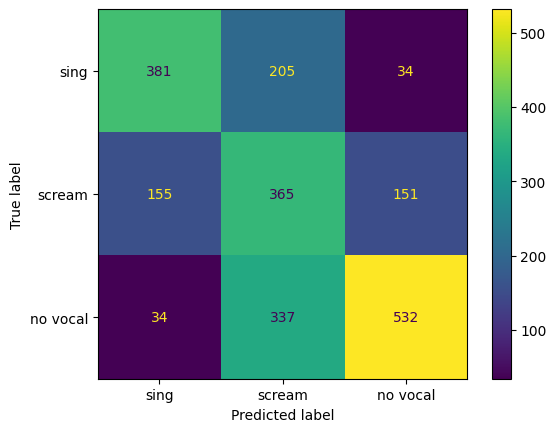

In [7]:
model = keras.models.load_model('/content/model')

y_pred=model.predict(X_valid)
y_pred[np.where(y_pred==np.max(y_pred))] = 1

predicted=np.argmax(y_pred, axis=1)
ground_truth=np.argmax(y_valid_hot, axis=1)

cm=confusion_matrix(ground_truth,predicted)
score=precision_score(ground_truth,predicted, average='macro')
acc = accuracy_score(ground_truth,predicted)


print(f"Overall Accuracy Score: {acc}")
print("Class-wise accuracy:")
for row in cm:
    print(row/row.sum())
print(f"Macro Accuracy: {score}")

print("Confusion Matrix:")
# print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sing','scream','no vocal']).plot()

Splitting the predictions and ground truth in seperate song segments

In [8]:
big_predicted = {}
big_gt = {}
sub_predicted = []
sub_gt = []
id = 0

current_song = df['video_id'][0]
for i in range(len(df)):
  if(current_song != df['video_id'][i]):
    title = lut['band_name'][id] + " - " +  lut['song_name'][id]
    id += 1
    big_predicted[title] = sub_predicted
    big_gt[title] = sub_gt
    sub_predicted = []
    sub_gt = []
    current_song = df['video_id'][i]

  sub_predicted.append(predicted[i])
  sub_gt.append(ground_truth[i])

title = lut['band_name'][id] + " - " +  lut['song_name'][id]
big_predicted[title] = sub_predicted
big_gt[title] = sub_gt

Create the vocal classification graph for each song

Ne Obliviscaris - Libera (Part I) Saturnine Spheres
Accuracy: 0.739240506329114


<ipython-input-9-7d662dc3901a>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(labels)
<ipython-input-9-7d662dc3901a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(labels)


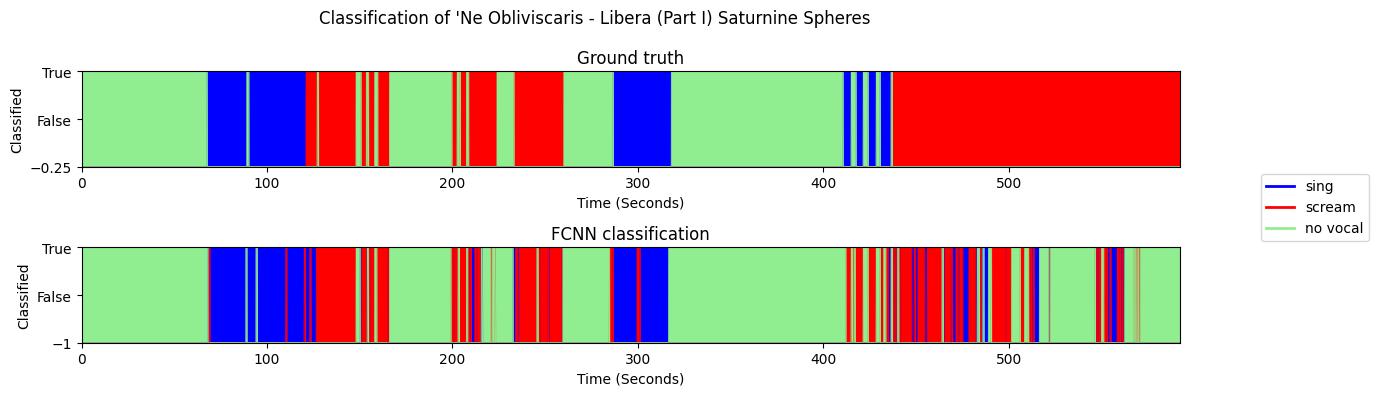

Xanthochroid - Of Aching Empty Pain
Accuracy: 0.398414271555996


<ipython-input-9-7d662dc3901a>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(labels)
<ipython-input-9-7d662dc3901a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(labels)


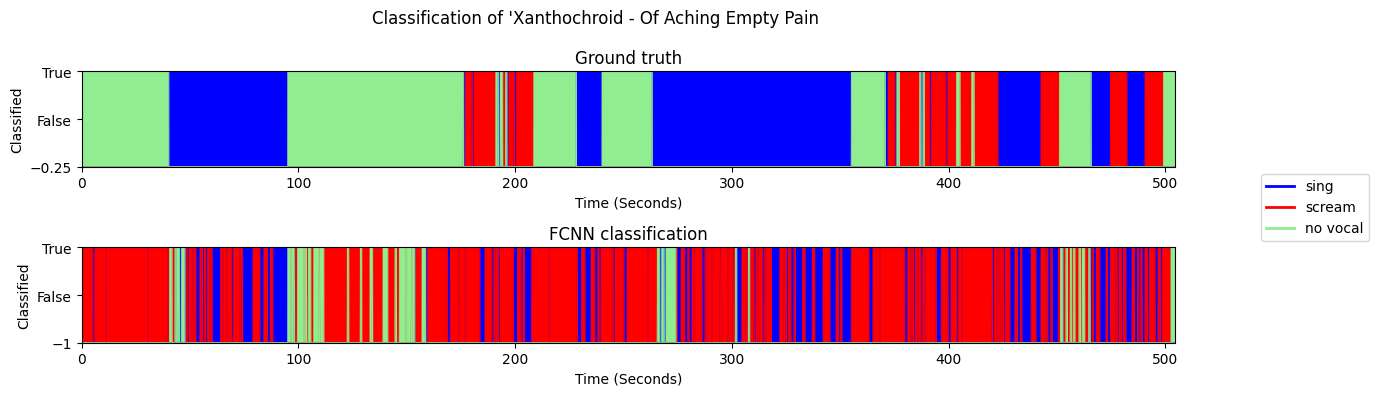

In [9]:
import matplotlib.pyplot as plt
for name in big_predicted:
  xsing = []
  ysing = []
  xscream = []
  yscream = []
  xmute = []
  ymute = []
  txsing = []
  tysing = []
  txscream = []
  tyscream = []
  txmute = []
  tymute = []

  print(name)
  acc = accuracy_score(big_predicted[name], big_gt[name])
  print("Accuracy: " + str(acc))

  # 0: sing
  # 1: scream
  # 2: no vocal

  time = 0

  for x, tx in zip(big_predicted[name], big_gt[name]):
    sing = (x == 0)
    scream = (x == 1)
    mute = (x == 2)
    tsing = (tx == 0)
    tscream = (tx == 1)
    tmute = (tx == 2)

    #add 10 measurements to make the graph lines more vertical by
    #reducing the time difference to 0.05
    for y in range(10):
      xsing.append(time)
      xscream.append(time)
      xmute.append(time)

      txsing.append(time)
      txscream.append(time)
      txmute.append(time)

      ysing.append(sing)
      yscream.append(scream)
      ymute.append(mute)

      tysing.append(tsing)
      tyscream.append(tscream)
      tymute.append(tmute)

      time += 0.05
    # time += 0.5

  fig, ax = plt.subplots(2, figsize = (12, 4))
  ax[1].plot(xsing, ysing, label = "sing", color='blue', fillstyle='bottom', linewidth=0.1)
  ax[1].fill_between(xsing, 0, ysing, color='blue')
  ax[1].plot(xscream, yscream, label = "scream", color='red', fillstyle='bottom', linewidth=0.1)
  ax[1].fill_between(xscream, 0, yscream, color='red')
  ax[1].plot(xmute, ymute, label = "no vocal", color='lightgreen', fillstyle='bottom', linewidth=0.1)
  ax[1].fill_between(xmute, 0, ymute, color='lightgreen')

  plt.locator_params(axis='y', nbins=2)

  fig.canvas.draw()

  labels = [item.get_text() for item in ax[1].get_yticklabels()]
  labels[1] = 'False'
  labels[2] = 'True'
  ax[1].set_yticklabels(labels)
  ax[1].set_title('FCNN classification')
  # fig.suptitle("Classification of \'" + lut.iloc[0][1] + "\' by " + lut.iloc[0][0])
  fig.suptitle("Classification of \'" + name)
  ax[1].set(xlabel='Time (Seconds)', ylabel='Classified')
  ax[1].use_sticky_edges = True
  ax[1].margins(x=0,y=0)

  ax[0].plot(txsing, tysing, label = "sing", color='blue', fillstyle='bottom', linewidth=0.1)
  ax[0].fill_between(txsing, 0, tysing, color='blue')
  ax[0].plot(txscream, tyscream, label = "scream", color='red', fillstyle='bottom', linewidth=0.1)
  ax[0].fill_between(txscream, 0, tyscream, color='red')
  ax[0].plot(txmute, tymute, label = "no vocal", color='lightgreen', fillstyle='bottom', linewidth=0.1)
  ax[0].fill_between(txmute, 0, tymute, color='lightgreen')

  labels = [item.get_text() for item in ax[0].get_yticklabels()]
  labels[1] = 'False'
  labels[2] = 'True'
  ax[0].set_yticklabels(labels)
  ax[0].set_title('Ground truth')
  ax[0].set(xlabel='Time (Seconds)', ylabel='Classified')
  ax[0].use_sticky_edges = True
  ax[0].margins(x=0,y=0)

  handles, labels = ax[0].get_legend_handles_labels()
  leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.1, 0.585))
  for line in leg.get_lines():
      line.set_linewidth(2)

  fig.tight_layout()
  plt.show()